In [1]:
# A décommenter à la première exécution si jupyter se plaint de ne pas trouver oracledb
#!pip install --upgrade oracledb

In [10]:
# Compléter ici les imports dont vous avez besoin, ne pas modifier ceux déjà présents
import getpass
from os import getenv
import pandas as pd
import oracledb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Nécessaire pour éviter les problèmes de session
class Connexion(object):
    def __init__(self, login, password):
        self.conn = oracledb.connect(
            user=login,
            password=password,
            host="oracle.iut-orsay.fr",
            port=1521,
            sid="etudom",
        )
        self.conn.autocommit = False

    def __enter__(self):
        self.conn.autocommit = False
        return self.conn

    def __exit__(self, *args):
        self.conn.close()

In [3]:
# La fonction ci-dessous est à utiliser pour exécuter une requête et stocker les résultats dans un dataframe Pandas sans afficher d’alerte.
# Vous pouvez vous en inspirer pour créer vos propres fonctions.
def requete_vers_dataframe(connexion_data, requete, valeurs = None):
    with Connexion(login=connexion_data['login'], password=connexion_data['password']) as connexion:
        warnings.simplefilter(action='ignore', category=UserWarning)
        if valeurs is not None:
            df = pd.read_sql(requete, connexion, params=valeurs)
        else:
            df = pd.read_sql(requete, connexion)
        warnings.simplefilter("always") 
        return df

In [4]:
# Saisir ci-dessous la plateforme qui vous a été attribuée. Cela correspond au nomPlateforme dans la table PLATEFORME de la base de données
# Par exemple NOM_PLATEFORME = "Switch"
NOM_PLATEFORME = "Sega Saturn"
# Saisir ci-dessous le login court de la base utilisée pour votre carnet
SCHEMA = '"ILUIS"'

```python
# Gestion des droits de ANALYSEJV déjà effectué lorsque connecté par iluis
tables = [
    '"CATEGORIEJEU"', '"CATEGORIEPLATEFORME"', '"CLASSIFICATIONAGE"', '"COMPAGNIE"',
    '"DATESORTIE"', '"FRANCHISE"', '"JEU"', '"GENRE"', '"MODALITE"', '"MODEMULTIJOUEUR"',
    '"MOTCLE"', '"MOTEUR"', '"PLATEFORME"', '"POPULARITE"', '"REGION"', '"THEME"', '"TITREALTERNATIF"',
    '"LOCALISATIONJEU"', '"MOTCLEJEU"', '"GENREJEU"', '"SIMILARITE"', '"CLASSIFICATIONJEU"', '"COMPAGNIEJEU"',
    '"MOTEURJEU"', '"PLATEFORMEMOTEUR"', '"THEMEJEU"', '"FRANCHISEJEU"', '"MODALITEJEU"'
]

with Connexion(login=conn['login'], password=conn['password']) as connexion:
    connexion.begin()
    curseur = connexion.cursor()
    utilisateur = '"ANALYSEJV"'
   
    for table in tables:
        sql_grant = f"""
        GRANT SELECT ON {SCHEMA}.{table} TO {utilisateur}
        """
        curseur.execute(sql_grant)
       
    sql_grant = f"""
    GRANT EXECUTE ON {SCHEMA}.DETAILS_SORTIES TO {utilisateur}
    """
    curseur.execute(sql_grant)
    connexion.commit()
    curseur.close()

print("✅ Droits accordés à l'utilisateur AnalyseJV")

In [170]:
# On demande à l'utilisateur son login et mot de passe pour pouvoir accéder à la base de données
if getenv("DB_LOGIN") is None:
    login = input("Login : ")
else:
    login = getenv("DB_LOGIN")
if getenv("DB_PASS") is None:
    password = getpass.getpass("Mot de passe : ")
else:
    password = getenv("DB_PASS")
conn = {'login': login, 'password': password}

Login :  iluis
Mot de passe :  ········


In [171]:
# On vérifie que l'utilisateur est bien connecté à la base de données, que le schéma est bon, et qu'on trouve la bonne édition des JO
data = requete_vers_dataframe(conn, f"SELECT * FROM {SCHEMA}.PLATEFORME WHERE nomPlateforme LIKE (:libelle)",{"libelle":NOM_PLATEFORME})
id_plateforme = int(data.IDPLATEFORME.iloc[0])
print(f"Identifiant de la plateforme : {id_plateforme}")

Identifiant de la plateforme : 32


# TABLEAU DE analyse statistique 

# 1. Présentation générale de la plateforme : Sega Saturn

## Contexte historique

La **Sega Saturn** est une console de jeux vidéo de cinquième génération développée par la compagnie japonaise **SEGA**. Elle est sortie au Japon en **novembre 1994**, en Amérique du Nord en **mai 1995** et en Europe en **juillet 1995**.

La Saturn succède à la **Sega Mega Drive (Genesis)** et précède la **Sega Dreamcast**, dernière console de Sega. Elle fait donc partie de la **deuxième génération de consoles SEGA**, après les Master System et Mega Drive.

### Caractéristiques principales :
- Support : **CD-ROM**
- Architecture : **bi-processeur** (ce qui a complexifié le développement)
- Concurrents directs : **Sony PlayStation**, **Nintendo 64**
- Commercialisation active : **1994 – 2000**

Malgré un succès notable au Japon, la Saturn n’a pas connu le même engouement international que ses concurrentes, notamment à cause d’un marketing confus et de difficultés techniques pour les développeurs tiers.

> - Wikipédia – [Sega Saturn](https://fr.wikipedia.org/wiki/Sega_Saturn)
> - IGN – Console History: [https://www.ign.com](https://www.ign.com)
> - RetroGaming Wiki – Sega Saturn Overview

---

## Statistiques générales des jeux sur la Sega Saturn


# 1. Répartition des jeux par genre


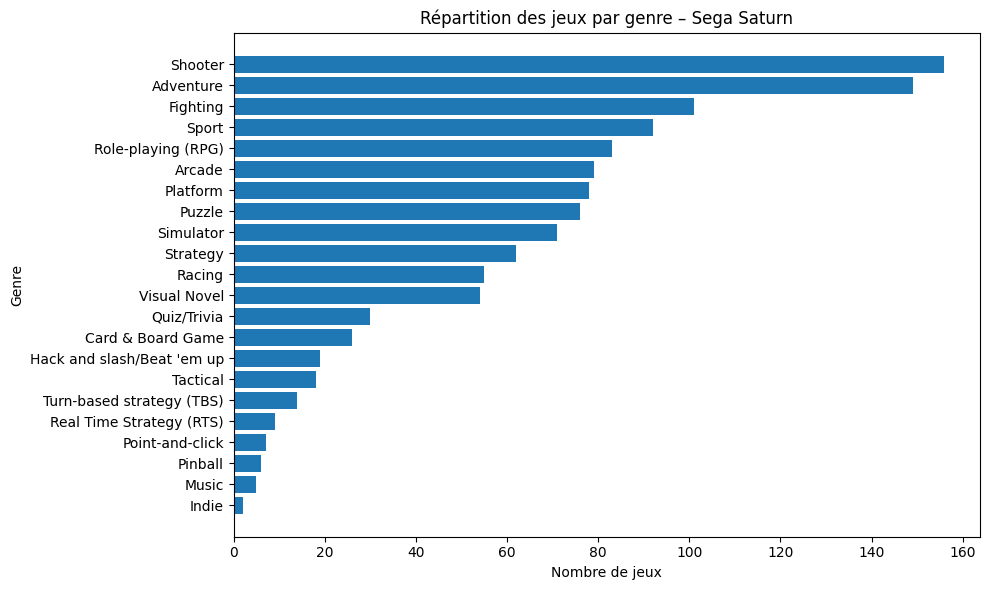

In [172]:
data_genre = requete_vers_dataframe(
    conn,
    f"""
    SELECT g.nomGenre, COUNT(*) AS nbJeux
    FROM {SCHEMA}.JEU j
    JOIN {SCHEMA}.GENREJEU gj ON j.idJeu = gj.idJeu
    JOIN {SCHEMA}.GENRE g ON gj.idGenre = g.idGenre
    JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
    WHERE ds.idPlateforme = 32
    GROUP BY g.nomGenre
    ORDER BY nbJeux DESC
    """
)

plt.figure(figsize=(10, 6))
plt.barh(data_genre["NOMGENRE"], data_genre["NBJEUX"])
plt.xlabel("Nombre de jeux")
plt.ylabel("Genre")
plt.title("Répartition des jeux par genre – Sega Saturn")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Le genre du Shooter n'etait pas très connue, mais vers les années 90, le genre c'est popularisé et c'est pour ça que le genre le plus produit sur Sega Neptun et le genre du shooter

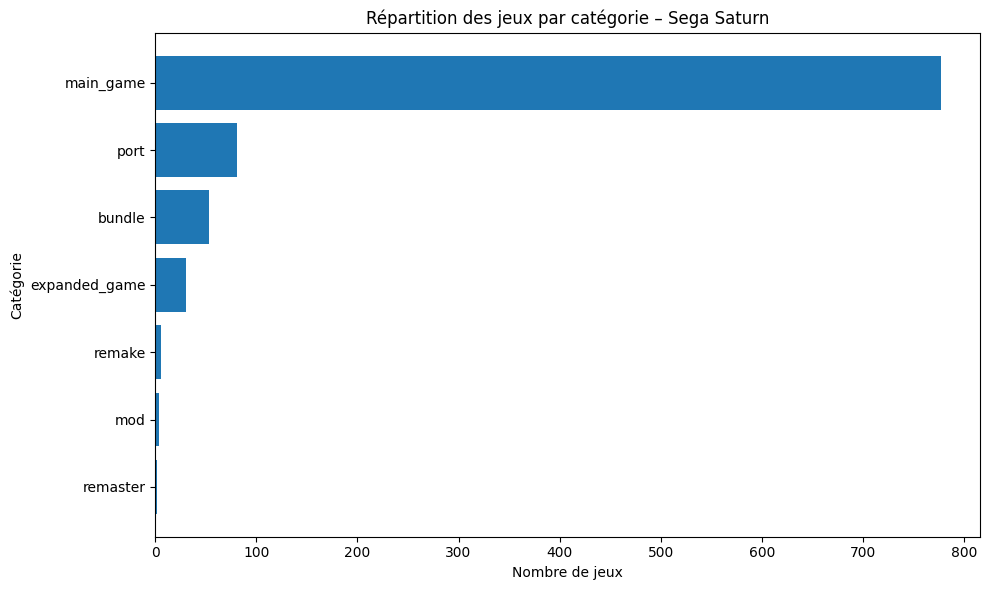

In [173]:
data_cat = requete_vers_dataframe(
    conn,
    f"""
    SELECT cj.nomCategorieJeu, COUNT(*) AS nbJeux
    FROM {SCHEMA}.JEU j
    JOIN {SCHEMA}.CATEGORIEJEU cj ON j.CategorieJeu = cj.idCategorieJeu
    JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
    WHERE ds.idPlateforme = 32
    GROUP BY cj.nomCategorieJeu
    ORDER BY nbJeux DESC
    """
)

plt.figure(figsize=(10, 6))
plt.barh(data_cat["NOMCATEGORIEJEU"], data_cat["NBJEUX"])
plt.xlabel("Nombre de jeux")
plt.ylabel("Catégorie")
plt.title("Répartition des jeux par catégorie – Sega Saturn")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



A l'epoque, les DLC, remake ou même les modes n'etait pas populaire voir inexistant, c'est pour ça que sur la Sega Neptune, il y a presque que des "main Game" soit des jeux principaux

In [174]:
# Requête pour comparer Sega avec les autres compagnies sur Sega Saturn
query_comparaison_compagnies = f"""
SELECT 
    c.nomCompagnie,
    COUNT(DISTINCT j.idJeu) AS nbJeux
FROM {SCHEMA}.JEU j
JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
JOIN {SCHEMA}.COMPAGNIEJEU cj ON cj.idJeu = j.idJeu
JOIN {SCHEMA}.COMPAGNIE c ON c.idCompagnie = cj.idCompagnie
WHERE ds.idPlateforme = 32
  AND cj.estDeveloppeur = 1
GROUP BY c.nomCompagnie
ORDER BY nbJeux DESC;
"""



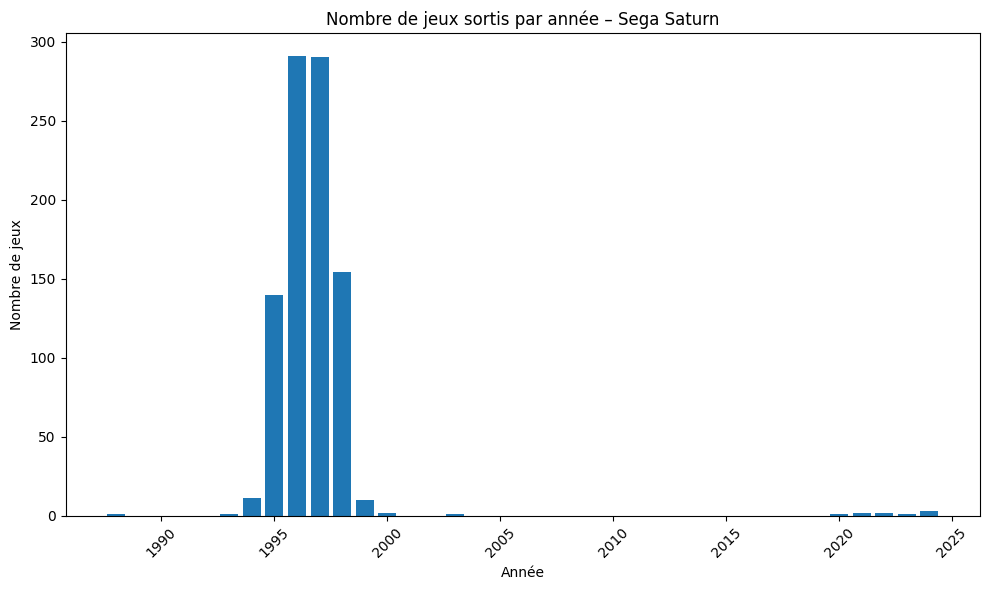

In [175]:
data_annee = requete_vers_dataframe(
    conn,
    f"""
    SELECT EXTRACT(YEAR FROM ds.dateSortie) AS annee, COUNT(*) AS nbJeux
    FROM {SCHEMA}.DATESORTIE ds
    WHERE ds.idPlateforme = 32
    GROUP BY EXTRACT(YEAR FROM ds.dateSortie)
    ORDER BY annee
    """
)

plt.figure(figsize=(10, 6))
plt.bar(data_annee["ANNEE"], data_annee["NBJEUX"])
plt.xlabel("Année")
plt.ylabel("Nombre de jeux")
plt.title("Nombre de jeux sortis par année – Sega Saturn")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Quand on regarde le graphique des jeux publié sur cette plateforme, on peut voir que l'année où il y a plus de jeux publiés est 1996, et que pendant une dizaine d'années il n'y a pas eu de publication. Ce qui est intéressant a voir avec se graphique, c'est qu'il y a des jeux qui ont été publié vers 2020, se sont des remake.

# 2. Comparaison de la Sega Saturn avec d'autres plateformes

### Statistiques de base

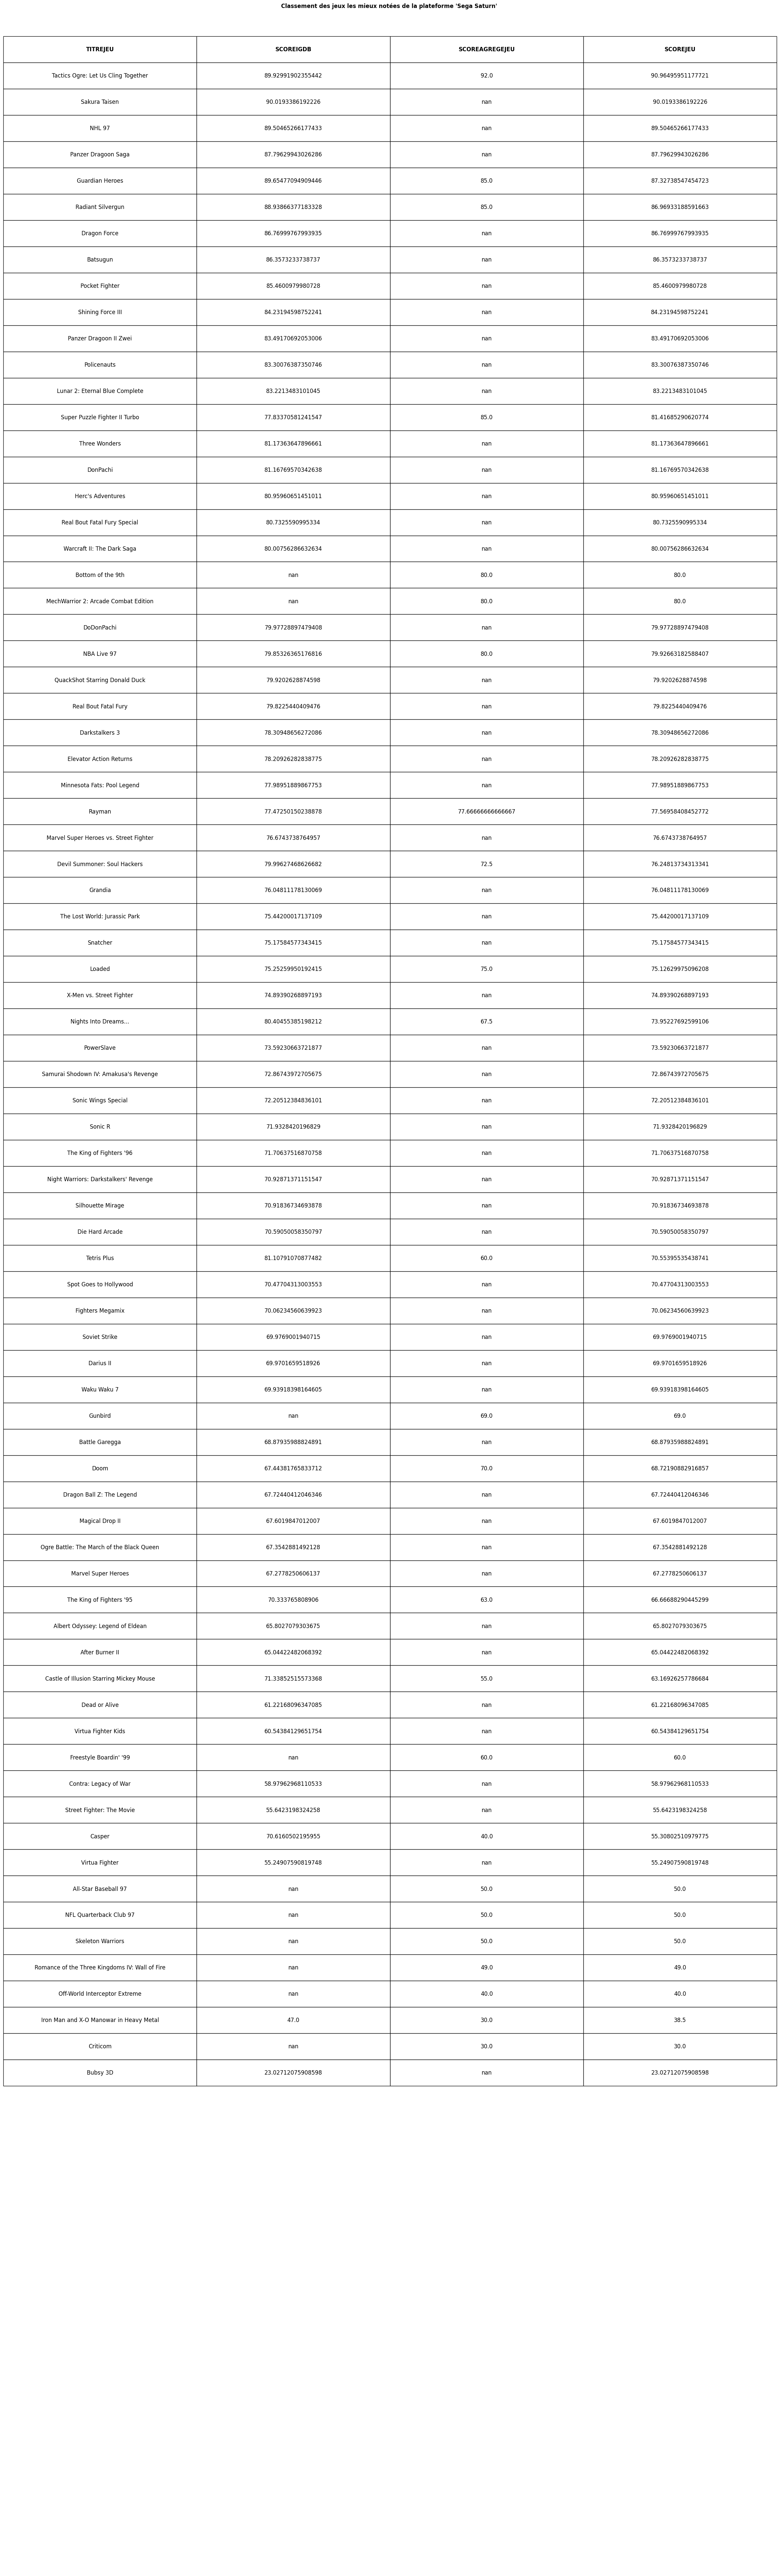

In [176]:
# Récupérer les données, les transformer si nécessaire, puis afficher sous forme de tableau
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT DISTINCT J.titreJeu, J.scoreIGDB, J.scoreAgregeJeu, J.ScoreJeu
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPlateforme = DS.idPlateforme
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.MODALITEJEU MJ ON MJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.MODALITE M ON M.idModalite = MJ.idModalite
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreJeu IS NOT NULL
    ORDER BY J.scoreJeu DESC
    """,
    {"libelle": NOM_PLATEFORME}
)

fig, ax = plt.subplots(figsize=(30, 100))  # Taille du graphique
data_top_10 = data.head(787)
ax.axis('off')

table1 = ax.table(cellText=data_top_10.values, colLabels=data_top_10.columns, loc='center', cellLoc='center', colLoc='center', bbox=[0, 0.19, 1, 0.8])

table1.auto_set_font_size(False)
table1.set_fontsize(12)

# première ligne en gras
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')

plt.title(f"Classement des jeux les mieux notées de la plateforme '{NOM_PLATEFORME}' ", fontweight='bold')
plt.show()

 Cette requête a pour but de récupérer des informations sur les jeux les mieux notés sur une plateforme spécifique, ici la plateforme Sega Saturn. Elle est sur les jeux développés par Sega et extrait des informations détaillées telles que :

- Le titre du jeu
- Le score IGDB
- Le score agrégé
- Le score combiné (scoreJeu)

Tout est classé par ordre décroissant de scoreJeu afin d'avoir les meilleurs jeux en haut du tableau

In [177]:
query = f"""
SELECT 
    c.nomCompagnie,
    c.paysCompagnie,
    j.scoreJeu
FROM {SCHEMA}.JEU j
JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
JOIN {SCHEMA}.COMPAGNIEJEU cj ON cj.idJeu = j.idJeu
JOIN {SCHEMA}.COMPAGNIE c ON cj.idCompagnie = c.idCompagnie
WHERE ds.idPlateforme = 32
  AND j.scoreJeu IS NOT NULL
  AND cj.estDeveloppeur = 1
"""

df = requete_vers_dataframe(conn, query)

groupes = {}
for i in range(len(df)):
    compagnie = df.iloc[i]["NOMCOMPAGNIE"]
    pays = df.iloc[i]["PAYSCOMPAGNIE"]
    score = df.iloc[i]["SCOREJEU"]
    key = (compagnie, pays)
    if key not in groupes:
        groupes[key] = []
    groupes[key].append(score)

def calculs_manuels(scores):
    scores.sort()
    n = len(scores)
    moyenne = sum(scores) / n
    variance = sum((x - moyenne)**2 for x in scores) / (n - 1) if n > 1 else 0
    ecart_type = variance ** 0.5
    min_val = scores[0]
    max_val = scores[-1]
    mediane = scores[n//2] if n % 2 else (scores[n//2 - 1] + scores[n//2]) / 2
    q1 = scores[n // 4]
    q3 = scores[(3 * n) // 4]
    return {
        "moyenne": round(moyenne, 2),
        "écart-type": round(ecart_type, 2),
        "min": min_val,
        "Q1": q1,
        "médiane": mediane,
        "Q3": q3,
        "max": max_val
    }

resultats = []
for (compagnie, pays), scores in groupes.items():
    stats = calculs_manuels(scores)
    stats["compagnie"] = compagnie
    stats["pays"] = pays
    resultats.append(stats)

import pandas as pd
df_resultat = pd.DataFrame(resultats)[
    ["compagnie", "pays", "moyenne", "écart-type", "min", "Q1", "médiane", "Q3", "max"]
]
display(df_resultat)




,compagnie,pays,moyenne,écart-type,min,Q1,médiane,Q3,max
0,Data East,392,74.53,6.00,67.601985,67.601985,77.989519,77.989519,77.989519
1,Game Arts,392,79.63,5.07,76.048112,76.048112,79.634730,83.221348,83.221348
2,CAVE Interactive,392,80.57,0.84,79.977289,79.977289,80.572492,81.167696,81.167696
3,Electronic Arts,840,69.98,0.00,69.976900,69.976900,69.976900,69.976900,69.976900
4,"Sega Enterprises, Ltd.",392,71.54,11.84,63.169263,63.169263,71.544763,79.920263,79.920263
5,SNK,392,73.08,6.14,66.666883,66.666883,72.286907,79.822544,80.732559
6,Ubi Pictures,250,77.57,0.00,77.569584,77.569584,77.569584,77.569584,77.569584
7,Psikyo,None,69.00,0.00,69.000000,69.000000,69.000000,69.000000,69.000000
8,Yumekobo,392,80.73,0.00,80.732559,80.732559,80.732559,80.732559,80.732559
9,J-Force,None,86.77,0.00,86.769998,86.769998,86.769998,86.769998,86.769998


Index(['NOMCOMPAGNIE', 'NOMPLATEFORME', 'MOYENNE_SCORE'], dtype='object')


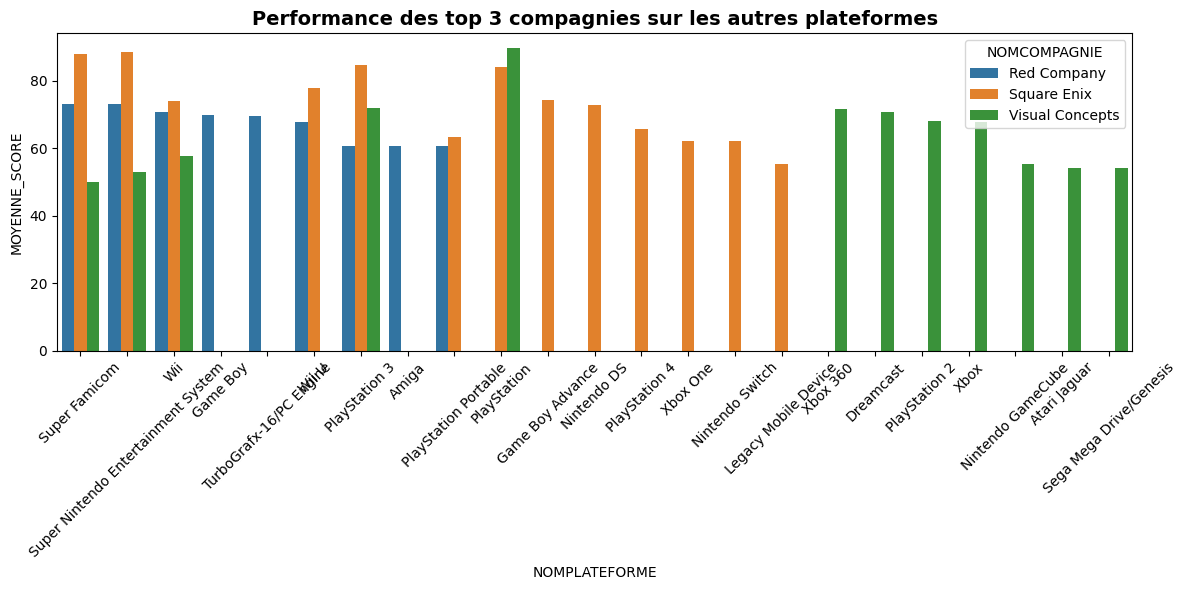

In [178]:
top3_compagnies = requete_vers_dataframe(
    conn,
    f"""
    SELECT CJ.idCompagnie, C.nomCompagnie, AVG(J.scoreJeu) AS moyenne_score
    FROM {SCHEMA}.JEU J
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE C ON CJ.idCompagnie = C.idCompagnie
    WHERE P.nomPlateforme LIKE :libelle AND J.scoreJeu IS NOT NULL
    AND CJ.estDeveloppeur = 1
    GROUP BY CJ.idCompagnie, C.nomCompagnie
    ORDER BY moyenne_score DESC
    FETCH FIRST 3 ROWS ONLY
    """,
    {"libelle": NOM_PLATEFORME}
)

top3_ids = top3_compagnies["IDCOMPAGNIE"].tolist()

params = {
    "libelle": NOM_PLATEFORME,
    "id1": top3_ids[0],
    "id2": top3_ids[1],
    "id3": top3_ids[2]
}

performance_autres_plateformes = requete_vers_dataframe(
    conn,
    f"""
    SELECT C.nomCompagnie, P.nomPlateforme, AVG(J.scoreJeu) AS moyenne_score
    FROM {SCHEMA}.JEU J
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    JOIN {SCHEMA}.COMPAGNIE C ON CJ.idCompagnie = C.idCompagnie
    WHERE CJ.idCompagnie IN (:id1, :id2, :id3)
      AND J.scoreJeu IS NOT NULL
      AND P.nomPlateforme != :libelle
      AND CJ.estDeveloppeur = 1
    GROUP BY C.nomCompagnie, P.nomPlateforme
    ORDER BY C.nomCompagnie, moyenne_score DESC
    """,
    params
)

print(performance_autres_plateformes.columns)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=performance_autres_plateformes,
    x="NOMPLATEFORME",       
    y="MOYENNE_SCORE",       
    hue="NOMCOMPAGNIE"      
)
plt.title("Performance des top 3 compagnies sur les autres plateformes", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

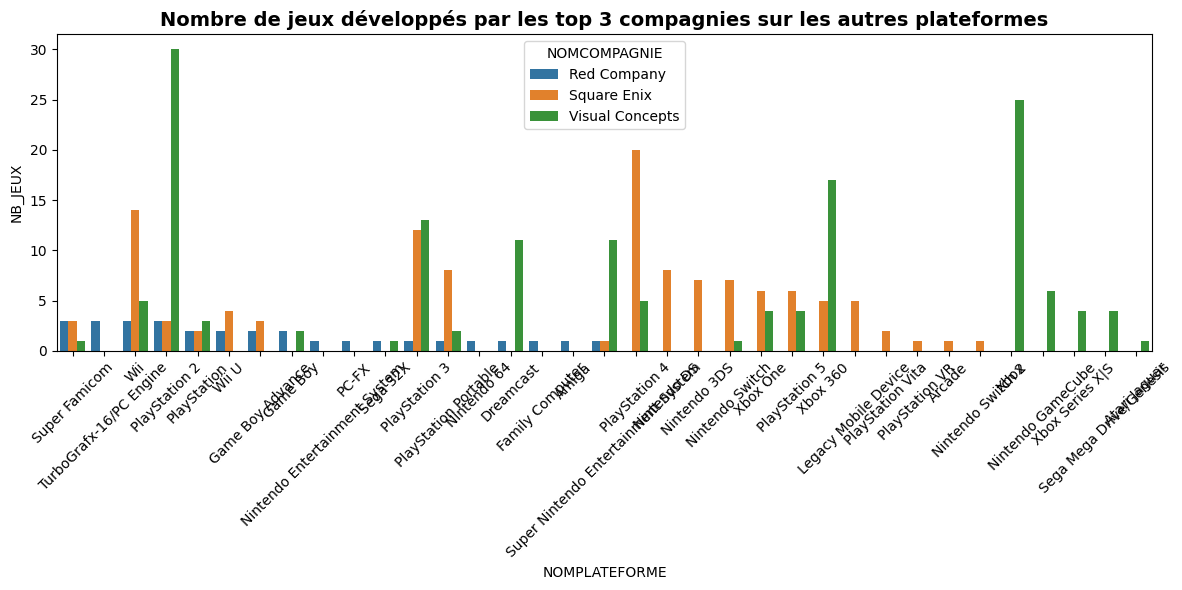

In [179]:
nombre_jeux_autres_plateformes = requete_vers_dataframe(
    conn,
    f"""
    SELECT C.nomCompagnie, P.nomPlateforme, COUNT(DISTINCT J.idJeu) AS nb_jeux
    FROM {SCHEMA}.JEU J
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE C ON CJ.idCompagnie = C.idCompagnie
    WHERE CJ.idCompagnie IN (:id1, :id2, :id3)
      AND P.nomPlateforme != :libelle
      AND CJ.estDeveloppeur = 1
    GROUP BY C.nomCompagnie, P.nomPlateforme
    ORDER BY C.nomCompagnie, nb_jeux DESC
    """,
    params
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=nombre_jeux_autres_plateformes,
    x="NOMPLATEFORME",   # Adapter si les colonnes sont en majuscules
    y="NB_JEUX",
    hue="NOMCOMPAGNIE"
)

plt.title("Nombre de jeux développés par les top 3 compagnies sur les autres plateformes", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

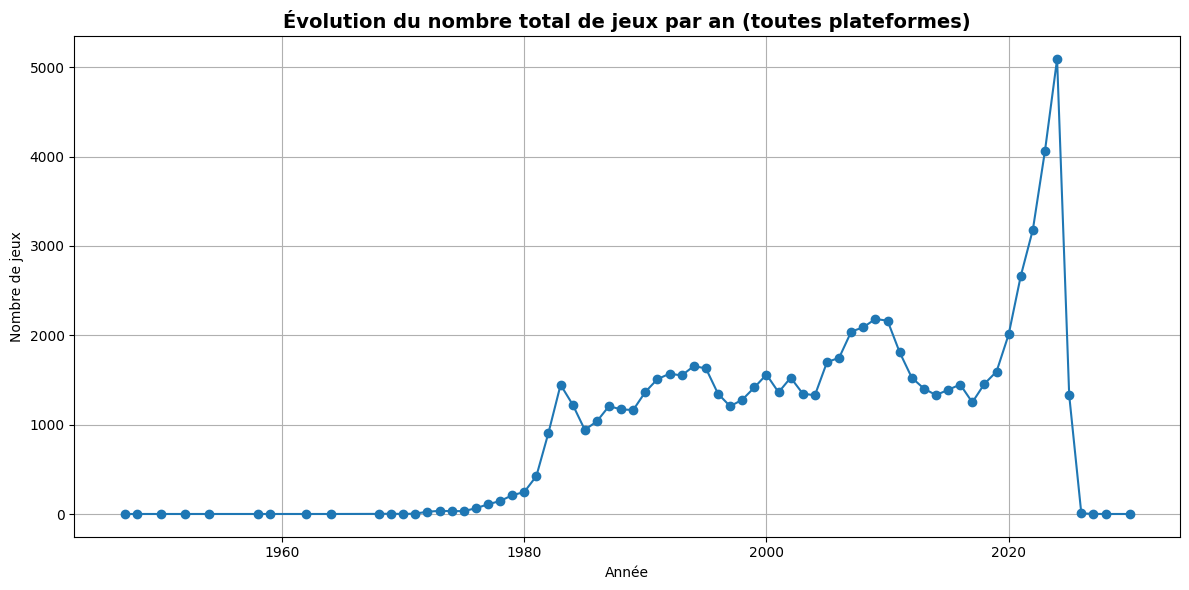

In [180]:
evolution_nb_jeux = requete_vers_dataframe(
    conn,
    f"""
    SELECT EXTRACT(YEAR FROM DS.dateSortie) AS annee, COUNT(DISTINCT J.idJeu) AS nb_jeux
    FROM {SCHEMA}.JEU J
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    WHERE DS.dateSortie IS NOT NULL
    GROUP BY EXTRACT(YEAR FROM DS.dateSortie)
    ORDER BY annee
    """
)

plt.figure(figsize=(12, 6))
plt.plot(evolution_nb_jeux["ANNEE"], evolution_nb_jeux["NB_JEUX"], marker='o')
plt.title("Évolution du nombre total de jeux par an (toutes plateformes)", fontsize=14, fontweight='bold')
plt.xlabel("Année")
plt.ylabel("Nombre de jeux")
plt.grid(True)
plt.tight_layout()
plt.show()


La courbe des jeux vidéo ne fait que augmenter car avant, les jeux vidéo étaient assez niche voir mal vus, mais au fur et à mesure du temps, l'industrie du jeu vidéo s'est démocratisée et est devenue tout public. Cette courbe du nombre de jeux totaux ne va faire que d'augmenter d'année en année car la popularité, elle aussi, ne fait que d'augmenter.

# 3. Contributions de 'Sega Entreprises, Ltd' sur la 'Sega Saturn'

In [181]:
# Calculer avec une requête et afficher le nombre de compagnies ayant développé sur cette plateforme
data = requete_vers_dataframe(
    conn,
    f"""
    SELECT COUNT(DISTINCT CJ.idJeu)
    FROM {SCHEMA}.PLATEFORME P
    INNER JOIN {SCHEMA}.DATESORTIE DS ON P.idPLATEFORME = DS.IdPlateforme
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE C ON C.idcompagnie = CJ.idcompagnie
    WHERE P.nomPlateforme LIKE :libelle AND CJ.idCompagnie = 4981
    """,
    {"libelle": NOM_PLATEFORME}
)

nbJeu = int(data.iloc[0, 0])
print("Nombre de jeux que 'Sega entrepries, Ltd' a développé sur la 'Sega Saturn': ", nbJeu)

Nombre de jeux que 'Sega entrepries, Ltd' a développé sur la 'Sega Saturn':  45


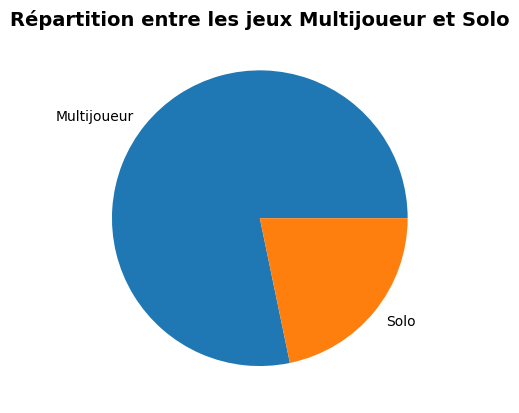

In [182]:
type_jeux = requete_vers_dataframe(
    conn,
    f"""
    SELECT COUNT(M.NomModalite)
    FROM {SCHEMA}.COMPAGNIEJEU CJ
    INNER JOIN {SCHEMA}.JEU J ON J.idJeu = CJ.idJeu
    INNER JOIN {SCHEMA}.MODALITEJEU MJ ON MJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.MODALITE M ON M.idModalite = MJ.idModalite
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    WHERE P.nomPlateforme LIKE :libelle AND idCompagnie = 4981 AND M.idModalite = 2
    """,
    {"libelle": NOM_PLATEFORME}
)

nbMulti = int(type_jeux.iloc[0, 0])
nbMulti = 100*nbMulti/45
nbSolo = 100*(45-nbMulti)/45
labels = 'Multijoueur', 'Solo'
sizes = [nbMulti, nbSolo]


plt.figure()
plt.title("Répartition entre les jeux Multijoueur et Solo", fontsize=14, fontweight = 'bold')
plt.pie(sizes, labels=labels)
plt.show()

On peut voir grace à ce graphique, que la spécialisation de cette compagnie sont les jeux vidéo multijoueurs 

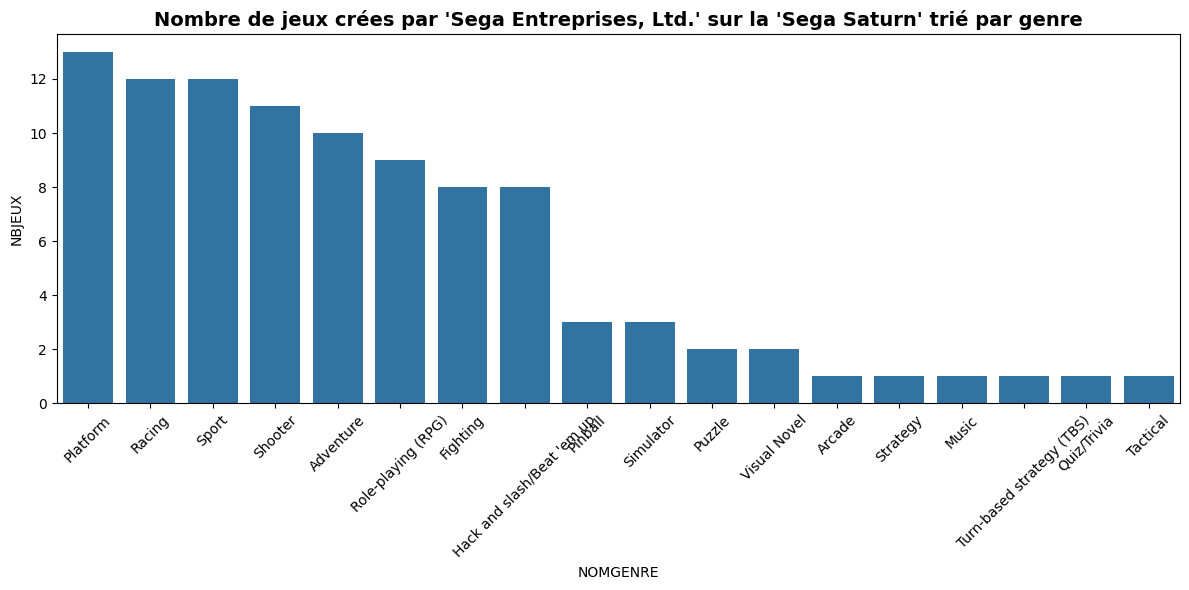

In [183]:
data_genre = requete_vers_dataframe(
    conn,
    f"""
    SELECT g.nomGenre, COUNT(*) AS nbJeux
    FROM {SCHEMA}.JEU j
    INNER JOIN {SCHEMA}.GENREJEU gj ON j.idJeu = gj.idJeu
    INNER JOIN {SCHEMA}.GENRE g ON gj.idGenre = g.idGenre
    INNER JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    WHERE ds.idPlateforme = 32 AND idCompagnie = 4981
    GROUP BY g.nomGenre
    ORDER BY nbJeux DESC
    """
)


plt.figure(figsize=(12, 6))
sns.barplot(
    data=data_genre,
    x="NOMGENRE",
    y="NBJEUX",
)

plt.title("Nombre de jeux crées par 'Sega Entreprises, Ltd.' sur la 'Sega Saturn' trié par genre", fontsize=14, fontweight = 'bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4 Comparaison de Sega Entreprises, Ltd avec 3 autres compagnies ( EA SPORT, Quest et Sega ) sur la Sega Saturn


In [184]:
compagnie4 = {
    "libelle": NOM_PLATEFORME,
    "id1": 4981,
    "id2": 1827,
    "id3": 112,
    "id4": 454
}

Index(['ANNEE', 'NBJEUX', 'NOMCOMPAGNIE'], dtype='object')


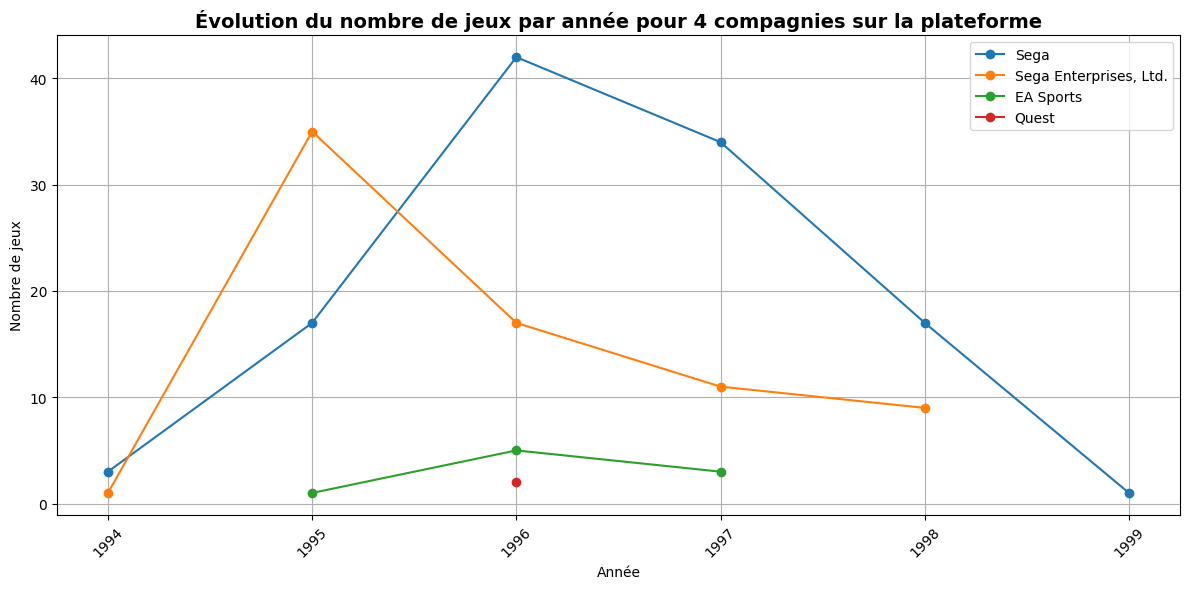

In [185]:
# Requête SQL pour récupérer les données des jeux par année et compagnie
TotJeu_top4 = requete_vers_dataframe(
    conn,
    f"""
    SELECT EXTRACT(YEAR FROM DS.dateSortie) AS annee, COUNT(*) AS nbJeux, C.nomCompagnie
    FROM {SCHEMA}.JEU j
    INNER JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE C ON C.idCompagnie = CJ.idCompagnie
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    WHERE P.nomPlateforme = :libelle AND CJ.idCompagnie IN (:id1, :id2, :id3, :id4)
    GROUP BY EXTRACT(YEAR FROM DS.dateSortie), C.nomCompagnie
    ORDER BY annee
    """,                                    
    compagnie4
)

# Vérification des colonnes du DataFrame
print(TotJeu_top4.columns)

# Suppression des lignes avec des valeurs manquantes dans les colonnes "ANNEE" ou "NBJEUX"
TotJeu_top4 = TotJeu_top4.dropna(subset=["ANNEE", "NBJEUX"])

# Conversion des colonnes en entier après avoir supprimé les valeurs manquantes
TotJeu_top4["ANNEE"] = TotJeu_top4["ANNEE"].astype(int)
TotJeu_top4["NBJEUX"] = TotJeu_top4["NBJEUX"].astype(int)

# 2. Création du graphique en courbes pour l'évolution des jeux par année pour chaque compagnie
plt.figure(figsize=(12, 6))

# Tracer la courbe pour chaque compagnie
for compagnie in TotJeu_top4["NOMCOMPAGNIE"].unique():
    compagnie_data = TotJeu_top4[TotJeu_top4["NOMCOMPAGNIE"] == compagnie]
    plt.plot(compagnie_data["ANNEE"], compagnie_data["NBJEUX"], marker='o', label=compagnie)

# Ajouter un titre et des labels
plt.title("Évolution du nombre de jeux par année pour 4 compagnies sur la plateforme", fontsize=14, fontweight='bold')
plt.xlabel("Année")
plt.ylabel("Nombre de jeux")
plt.xticks(rotation=45)
plt.grid(True)

# Ajouter une légende
plt.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()



On peut voir avec ce graphique, que Sega et Sega entreprises, Ltd on publiés beaucoup de jeux sur cette console ce qui est normal car c'est leur propre console, alors que Quest et EA Sport, n'ont pas publiés beaucoup de jeux mais ont publié des jeux de qualité car les 2 ont un jeu dans le top 25 des jeux les mieux notés de cette console.

Index(['NOMGENRE', 'NBJEUX', 'NOMCOMPAGNIE'], dtype='object')


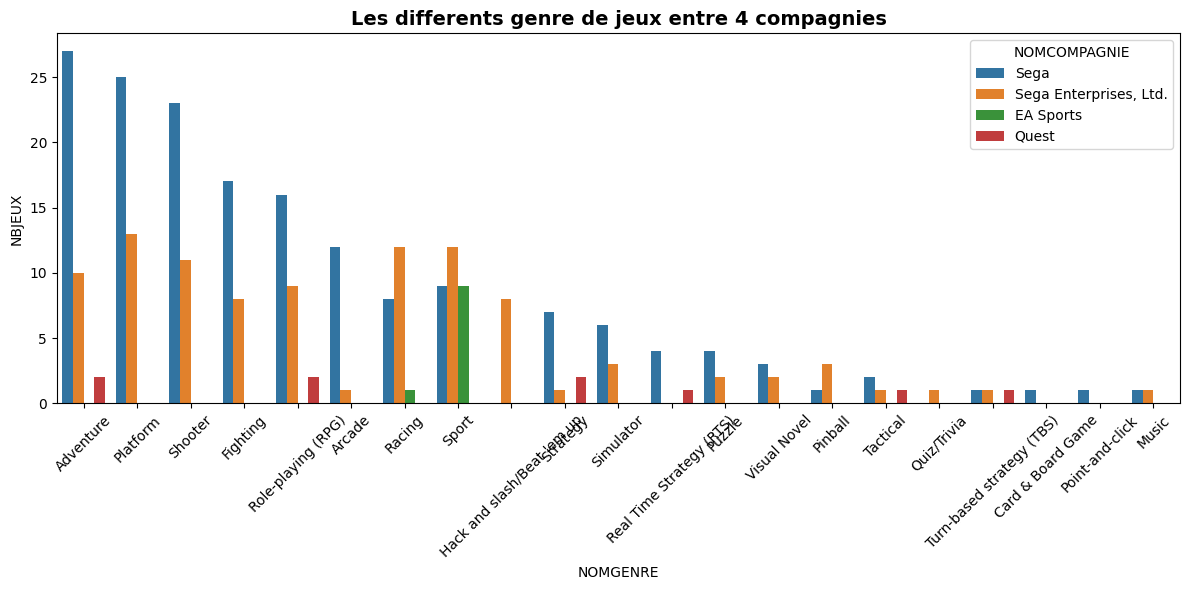

In [186]:
Genre_top4 = requete_vers_dataframe(
    conn,
    f"""
    SELECT g.nomGenre, COUNT(*) AS nbJeux, C.nomCompagnie
    FROM {SCHEMA}.JEU j
    INNER JOIN {SCHEMA}.GENREJEU gj ON j.idJeu = gj.idJeu
    INNER JOIN {SCHEMA}.GENRE g ON gj.idGenre = g.idGenre
    INNER JOIN {SCHEMA}.DATESORTIE ds ON ds.idJeu = j.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIE C ON C.idCompagnie = CJ.idCompagnie
    INNER JOIN {SCHEMA}.PLATEFORME P ON DS.idPlateforme = P.idPlateforme
    WHERE P.nomPlateforme = :libelle AND CJ.idCompagnie IN (:id1, :id2, :id3, :id4)
    GROUP BY g.nomGenre, C.nomCompagnie
    ORDER BY nbJeux DESC
    """,                                    
    compagnie4
)

print(Genre_top4.columns)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=Genre_top4,
    x="NOMGENRE",       
    y="NBJEUX",       
    hue="NOMCOMPAGNIE"      
)
plt.title("Les differents genre de jeux entre 4 compagnies", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5 Evolution de la compagnie

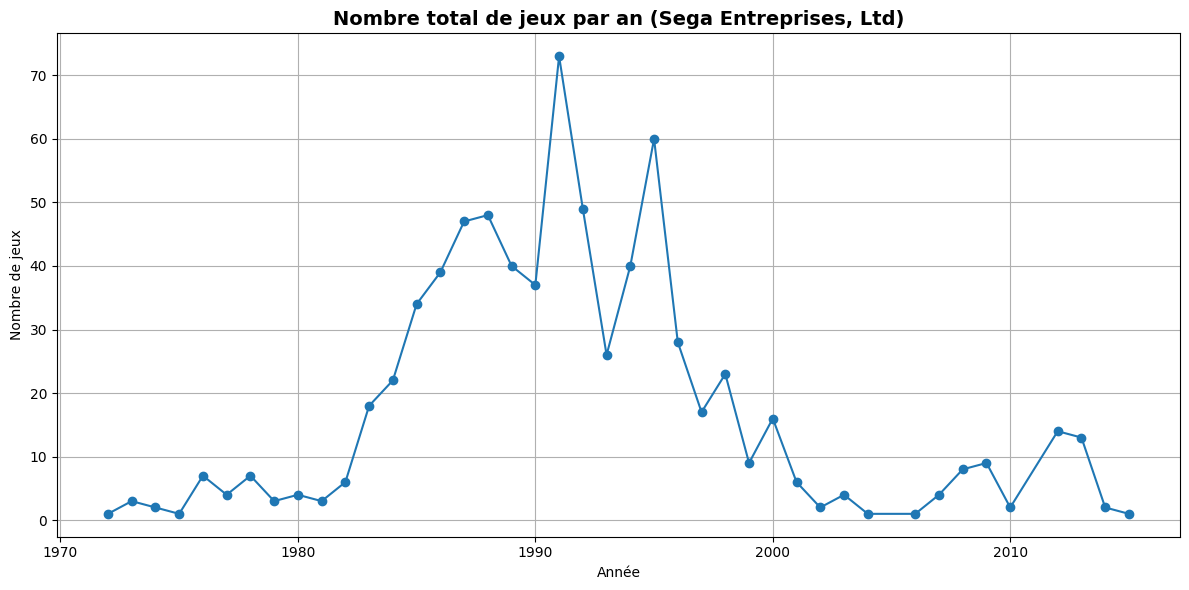

In [187]:
evolution_nb_jeux = requete_vers_dataframe(
    conn,
    f"""
    SELECT EXTRACT(YEAR FROM DS.dateSortie) AS annee, COUNT(DISTINCT J.idJeu) AS nb_jeux
    FROM {SCHEMA}.JEU J
    INNER JOIN {SCHEMA}.DATESORTIE DS ON J.idJeu = DS.idJeu
    INNER JOIN {SCHEMA}.COMPAGNIEJEU CJ ON CJ.idJeu = J.idJeu
    INNER JOIN {SCHEMA}.PLATEFORME P ON P.idPlateforme = DS.idPlateforme
    WHERE DS.dateSortie IS NOT NULL AND idCompagnie = 4981
    GROUP BY EXTRACT(YEAR FROM DS.dateSortie)
    ORDER BY annee
    """
)

plt.figure(figsize=(12, 6))
plt.plot(evolution_nb_jeux["ANNEE"], evolution_nb_jeux["NB_JEUX"], marker='o')
plt.title("Nombre total de jeux par an (Sega Entreprises, Ltd)", fontsize=14, fontweight='bold')
plt.xlabel("Année")
plt.ylabel("Nombre de jeux")
plt.grid(True)
plt.tight_layout()
plt.show()

#### On peut voir que cette compagnie existe depuis longtemps, elle ne publiait pas beaucoup de jeux. Puis a partir de 1982, elle n'a fait qu'augmenter jusqu'a arriver a 74 jeux vendu en 1992. Ensuite elle n'a fait que diminuer (a part l'augmentation vers 2010) jusqu'a arriver a 1 jeu publié en 2015. Cette compagnie a donc crée de nombreux jeux mais a present elle ne produit plus beaucoup voir plus dutout. Dans le future cette entreprise va surment ne plus poster de jeux vidéo ou de temps en temps ( tous les 2 ans par exemples ) 